## Energy Detector using torch 

In [1]:
import os
import sys
import time

import numpy as np
import torch

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf

import torchnet.meter as tnt
from collections import OrderedDict

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

import ai8x

from types import SimpleNamespace
from msnoise import MSnoise
import msnoise

from mixedkws import MixedKWS
import mixedkws

In [2]:
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-synthesis/trained/","ai85-kws20_v3-qat8.pth.tar")              #degisecek
mod = importlib.import_module("ai85net-kws20-v3")
dataset = importlib.import_module("kws20")

classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']
           
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
# qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))

_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)

Working with device: cuda
Configuring device: MAX78000, simulate=False.
No key `strech` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36
Finished in 0.560 seconds.
Processing the label: bed. 2 of 36
Finished in 0.300 seconds.
Processing the label: bird. 3 of 36
Finished in 0.301 seconds.
Processing the label: cat. 4 of 36
Finished in 0.295 seconds.
Processing the label: dog. 5 of 36
Finished in 0.312 seconds.
Processing the label: down. 6 of 36
Finished in 0.531 seconds.
Processing the label: eight. 7 of 36
Finished in 0.522 seconds.
Processing the label: five. 8 of 36
Finished in 0.557 seconds.
Processing the label: follow. 9 of 36
Finished in 0.217 seconds.
Processing the label: forward. 10 of 36
Finished in 0.216 seconds.
Processing the label: four. 11 of 36
Finished in 0.508 seconds.
Processing the label: go. 12 of 36
Finished in 0.533 seconds.
Processing the label: happy. 13 of 36
Finished in 0.286 seconds.
Processing t

In [180]:
rand = np.random.randint(0, len(test_dataset))

In [181]:
sample, target = test_dataset[rand]

In [182]:
sample, target

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 20)

In [183]:
import torchaudio
from torchaudio.sox_effects import apply_effects_tensor
from torchaudio import transforms

In [184]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', 16384, np.array(sample).flatten('F'))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', rate = 16384)

In [185]:
waveform, sample_rate = torchaudio.load("test.wav")
waveform_reversed, sample_rate = apply_effects_tensor(waveform, sample_rate, [["reverse"]])
transform = transforms.Vad(sample_rate=sample_rate)
waveform_reversed_front_trim = transform(waveform_reversed)
waveform_end_trim, sample_rate = apply_effects_tensor(waveform_reversed_front_trim, sample_rate, [["reverse"]])
waveform_end_front_trim = transform(waveform_end_trim)

In [186]:
waveform_end_trim.shape

torch.Size([1, 11470])

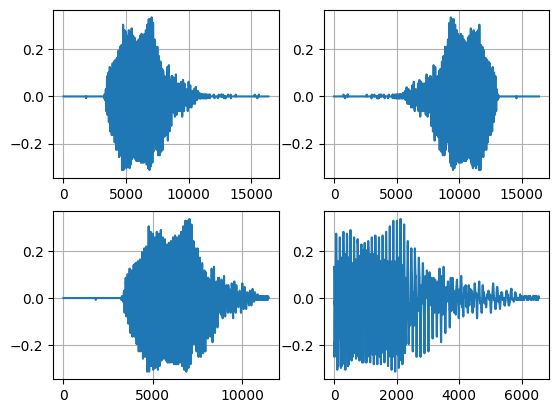

In [187]:
plt.subplot(2,2,1)
plt.plot(np.array(waveform).flatten('F'))
plt.grid()
plt.subplot(2,2,2)
plt.plot(np.array(waveform_reversed).flatten('F'))
plt.grid()
plt.subplot(2,2,3)
plt.plot(np.array(waveform_end_trim).flatten('F'))
plt.grid()
plt.subplot(2,2,4)
plt.plot(np.array(waveform_end_front_trim).flatten('F'))
plt.grid()

In [194]:
end = len(waveform[0]) - len(waveform_end_trim[0])

In [195]:
end

4914

In [193]:
len(waveform_end_front_trim[0])

6548

In [190]:
end = start * 2

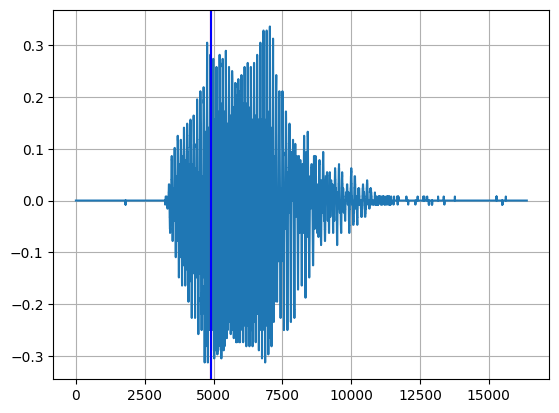

In [196]:
plt.plot(np.array(waveform).flatten('F'))
plt.axvline(x = end, color = 'red', label = 'start')
plt.axvline(x = end, color = 'blue', label = 'end')
plt.grid()

waveform_reversed_front_trim basini kesiyo verinin

In [98]:
waveform_reversed_front_trim.shape

torch.Size([1, 11470])

In [99]:
len(waveform_reversed_front_trim[0])

11470

In [100]:
waveform_reversed_front_trim.shape

torch.Size([1, 11470])

In [101]:
length = len(waveform_reversed_front_trim[0]) + len(waveform_end_trim[0])
waveform[0][len(waveform_reversed_front_trim[0]): length]

tensor([0.0156, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

In [102]:
len(waveform_end_trim[0])

11470

In [103]:
waveform

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])